# Data Visualization of the data

Submitted by : Mayank Bhardwaj, Neha Jain, Rishupal Singh Chabbra

## A. Plotting the line graph of air temperature against arrival time

The air temperature data received from Producer 1 i.e. Climate data is plotted against its arrival time.<br>For this we are using the Kafka Consumer and plotting the data as soon as it received. The data will only be plotted once atleast 10 data points are received.

Addtionally we have set the markers for each data point and the minium and maximum values in particular window of length 10 is marked using arrows, arrow red for maximum value and arrow orange for minimum value

<IPython.core.display.Javascript object>


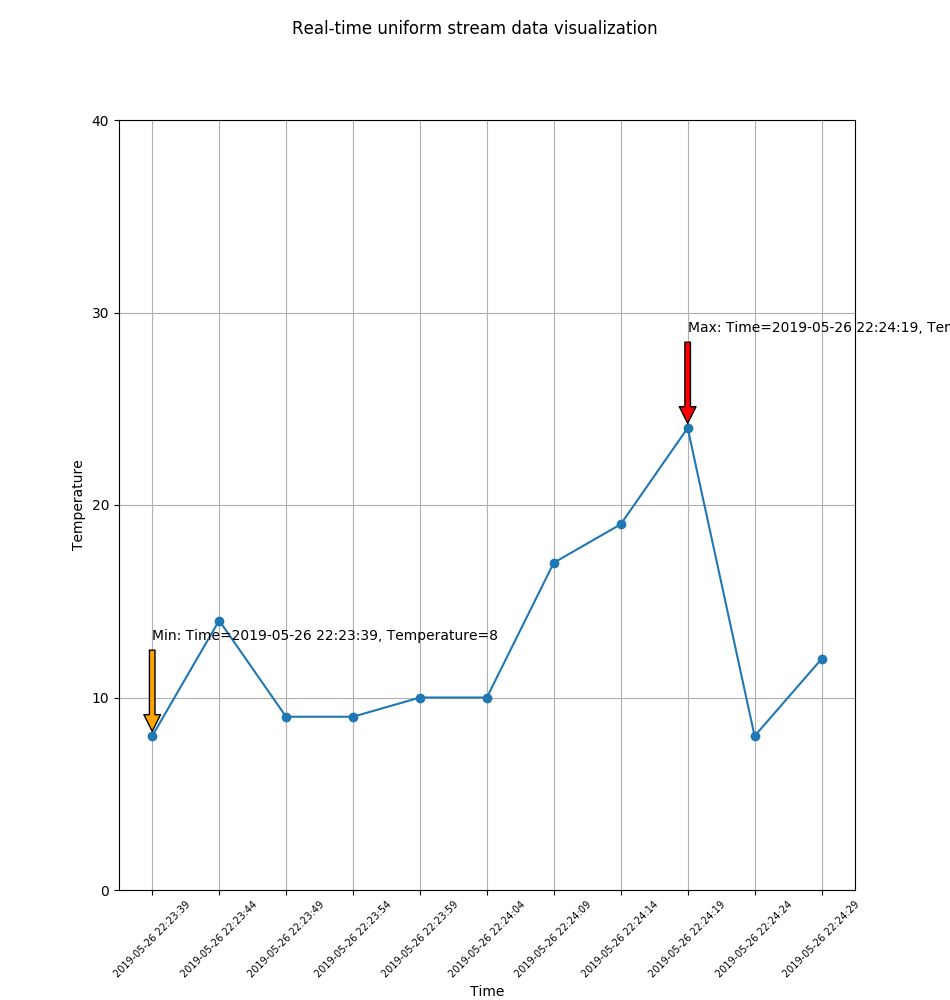

KeyboardInterrupt: 

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.0 pyspark-shell'


import sys
import time
import json
from pymongo import MongoClient
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
import matplotlib.pyplot as plt
import matplotlib
from kafka import KafkaConsumer
%matplotlib notebook


topic = "climate"

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer 
    
def init_plots():
    try:
        width = 9.5
        height = 10
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Temperature')
        ax.set_ylim(0,40) 
        ax.set_yticks([0,10,20,30,40])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Temperature={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Temperature={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        
        # print('Waiting for messages')
        for message in consumer:
            data = None
            data = message.value.decode('utf-8').replace("'", '"')
            data = json.loads(data)
            if data["sender_id"] == "P1":
                x.append(data["created_time"])
                y.append(int(data["air_temperature_celcius"]))
            
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y, marker = 'o')
                ax.set_xlabel('Time')
                ax.tick_params(axis= 'x', labelsize = 7, labelrotation=45)
                ax.grid(which = 'both')
                ax.set_ylabel('Temperature')
                ax.set_ylim(0,40) 
                ax.set_yticks([0,10,20,30,40])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                fig.show()
                
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
   
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)




## B. Static Data Visualisation

### 1. Bar plot of records with top 10 number of fires

In [2]:
import matplotlib.pyplot as plt
from pprint import pprint

In [3]:
from pymongo import MongoClient

client = MongoClient()
db = client.fit5148_assignment_db
climate = db.climate
hotspot = db.hotspot

First we aggregate the entire climate data based on the time interval of 5 mins each, i.e. data is divided into 5 mins time interval. This is acheived by using the subtract and mod function below to find the records in 5 mins time intervals. <br> Next we append the count and the time to a list of tuples and unzip it for plotting.

In [4]:
x1 = hotspot.aggregate([
    {"$group": {
        "_id" : { #found the time interval
                "datetime": {"$concat":[ 
                    {"$substr": [{"$year": {'$dateFromString': {'dateString': "$datetime"}}}, 0, 4 ]},
                    "-",
                    {"$substr": [{"$month": {'$dateFromString': {'dateString': "$datetime"}}}, 0, 2 ]},
                    "-",
                    {"$substr": [{"$dayOfMonth": {'$dateFromString': {'dateString': "$datetime"}}}, 0, 2 ]},
                    " ",
                    {"$substr": [{"$hour": {'$dateFromString': {'dateString': "$datetime"}}}, 0, 2 ]},
                    ":",
                    {'$substr':[ {"$subtract": [ 
                           { "$minute": {'$dateFromString': {'dateString': "$datetime"}} },
                           { "$mod": [{ "$minute": {'$dateFromString': {'dateString': "$datetime"}} }, 5] }
                            ]}, 0, 2]}
                ]}
            },
        
        "count": {"$sum": 1 } # found the number of fire records in that time interval of 5 mins
     }},
  
    {'$sort':{"count":-1}},  # sorted the count to find top 10 records
    {'$limit': 10} 
])

l = []
for each in x1:
    l.append((each['_id']['datetime'], each['count']))
    
date, count = zip(*l) 

Plotting the bar chart of the above data

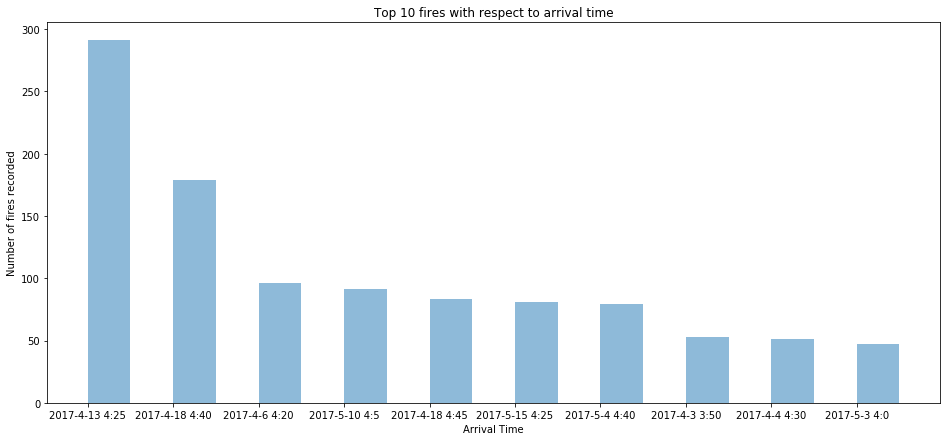

In [5]:
plt.figure(figsize=(16,7))
plt.bar(date, count, align='edge',width = 0.5, alpha = 0.5)
plt.title("Top 10 fires with respect to arrival time")
plt.xlabel("Arrival Time")
plt.ylabel("Number of fires recorded")
plt.show()

## 2. Fire locations on Map along with other details

Next we plot the map with given latitude and longitude values and respective details of climate and fire i.e. surface_temperature_celcius, confidence, air_temperature_celcius and relative_humidity.<br>We are using gmplot and GoogleMapPlotter for this.

In case the below code doesnot work, and error occurs with gmplot, please update gmplot using the below command<br><br>sudo pip3 install --upgrade python3 gmplot

In [6]:
from gmplot import gmplot
# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.812, 144.9514, 10) # latitude and longitude of melbourne city
gmap.coloricon = "http://www.googlemapsmarkers.com/v1/%s/"

First we will pull all the required fields by joining the two collections using lookup function.

In [7]:
x3 = db.hotspot.aggregate([ {'$lookup' : 
                                     {'from': 'climate',
                                      'localField': 'climate',
                                      'foreignField': '_id',
                                      'as': 'climate' }},
                                     {'$project':{'climate.air_temperature_celcius':1,
                                                 'climate.relative_humidity':1,
                                                 'longitude':1,
                                                 'latitude':1,
                                                 'confidence':1,
                                                 'surface_temperature_celcius':1}}])

Now we plot out values on the map along with the mover over details stored in variable t below for each row in the result fetched above.

In [8]:
for x in x3:
    t = "surface temp: "+ str(x['surface_temperature_celcius'])+\
        ", confidence: " + str(x['confidence']) + ", air temp: "+ \
        str(x['climate'][0]['air_temperature_celcius']) +\
        ", relative humidity: "+ str(x['climate'][0]['relative_humidity'])
    x = gmap.marker(lat = float(x['latitude']), lng = float(x['longitude']),title=t)

In [9]:
import webbrowser
# Drawing the map
gmap.draw("FireAndClimateDetails.html")
webbrowser.open_new("FireAndClimateDetails.html")

True

A new tab with the plotted map will open and details can be seen there.